Epoch [1/20], Train Loss: 45.0419, Validation Loss: 38.2715
Epoch [2/20], Train Loss: 45.0971, Validation Loss: 38.2631
Epoch [3/20], Train Loss: 45.3044, Validation Loss: 38.2545
Epoch [4/20], Train Loss: 45.1362, Validation Loss: 38.2448
Epoch [5/20], Train Loss: 44.9385, Validation Loss: 38.2335
Epoch [6/20], Train Loss: 44.9327, Validation Loss: 38.2323
Epoch [7/20], Train Loss: 45.4046, Validation Loss: 38.2310
Epoch [8/20], Train Loss: 44.8760, Validation Loss: 38.2297
Epoch [9/20], Train Loss: 45.0559, Validation Loss: 38.2283
Epoch [10/20], Train Loss: 45.2667, Validation Loss: 38.2270
Epoch [11/20], Train Loss: 45.1488, Validation Loss: 38.2268
Epoch [12/20], Train Loss: 45.3375, Validation Loss: 38.2267
Epoch [13/20], Train Loss: 44.9293, Validation Loss: 38.2265
Epoch [14/20], Train Loss: 45.1630, Validation Loss: 38.2264
Epoch [15/20], Train Loss: 45.2957, Validation Loss: 38.2262
Epoch [16/20], Train Loss: 45.0037, Validation Loss: 38.2262
Epoch [17/20], Train Loss: 45.148

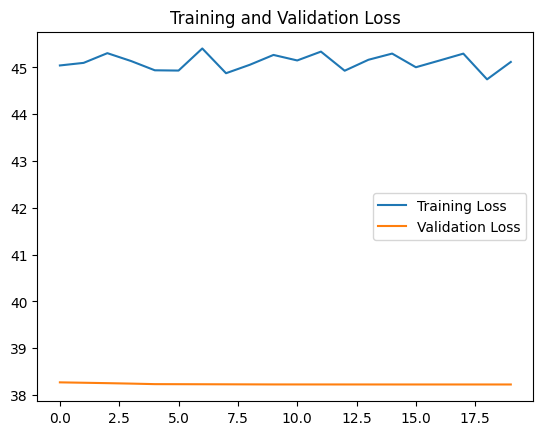

RMSE: 69.8458


In [4]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
import math

# Load Dataset
dataset_path = "../data/IPO_dataset.csv"  # Adjust path as needed
data = pd.read_csv(dataset_path)

# Define Features and Target
features = ['issue_price', 'issue_size', 'hni_subscription', 'nii_subscription',
            'rii_subscription', 'revenue_2', 'revenue_1', 'eps_2', 'eps_1']
target = 'listing_gain'

# Drop Missing Values
data = data.dropna(subset=features + [target])

# Scale Only Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])  # Scale features only
y = data[target].values  # Keep target unscaled

# Save the scaler for later use in prediction
with open("../models/scaler1.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data for LSTM input
# LSTM expects 3D input: [samples, time steps, features]
# Since there is no time step in this case (single row data), we treat each row as a single time step
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, time steps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, time steps, features)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM Model in PyTorch with multiple layers and Bidirectional LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)  # Increased dropout
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Output size after bidirectional LSTM

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])  # Take the last time step's output
        out = self.fc(out)
        return out

# Instantiate the model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # Size of the hidden layer
output_size = 1  # Single output (listing_gain)
model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function (Huber loss)
criterion = nn.SmoothL1Loss()

# Implement the Adam optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define scheduler for learning rate adjustment
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training Loop
num_epochs = 20
batch_size = 32
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 5  # Early stopping patience
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    permutation = torch.randperm(X_train_tensor.size(0))  # Shuffle the training data

    running_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)

    # Store losses for plotting
    train_losses.append(running_loss / (len(X_train_tensor) // batch_size))
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss / (len(X_train_tensor) // batch_size):.4f}, Validation Loss: {val_loss.item():.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model weights
        torch.save(model.state_dict(), "../models/best_lstm_model.pth")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement > patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Step scheduler for learning rate decay
    scheduler.step()

# Plot Training and Validation Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Optionally, save the training history
history = {'train_loss': train_losses, 'val_loss': val_losses}
with open("../models/training_history.pkl", "wb") as f:
    pickle.dump(history, f)

# Load best model after training completion
model.load_state_dict(torch.load("../models/best_lstm_model.pth"))

# Evaluate the model with RMSE on test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).detach().numpy()

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')
